<a href="https://colab.research.google.com/github/denisbebrovich/ML-DS/blob/main/LSTMsint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LSTM - специализированный слой рекуррентной нейронной сети, способной эффективно обрабатывать последовательные данные с длительными зависимостями. Сначала нейросеть обучается на нормальных данных и тренируется на них. После предсказания значений на тренировочных данных вычисляется разница между предсказанными и фактическими значениями, максимальная разница берется как трешхолд(норма). Далее проходит процесс тестирования, где входные данные подаются на обученную LSTM, модель предсказывает следующие значения в последовательности. Снова вычисляется разница между предсказанными и фактическими значениями. Если разница значительно отличается от трешхолда, это может указывать на наличие аномалии в данных.

Подключаем необходимые библиотеки


In [ ]:
import tensorflow as tf
from sklearn import svm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Открываем файл и считываем синтетические данные


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/new_data_sin_g.csv', index_col=0,
                 parse_dates=True)
df

,Value1,Value2,Value3,isAnomaly
Date,,,,
2023-06-01 00:00:00,0.078595,-0.064425,-0.066745,0
2023-06-01 00:05:00,0.108210,0.282256,0.100371,0
2023-06-01 00:10:00,0.413693,0.190801,0.011407,0
2023-06-01 00:15:00,0.160847,0.257206,0.450413,0
2023-06-01 00:20:00,0.296338,0.532423,0.372445,0
...,...,...,...,...
2023-07-05 16:55:00,0.419634,0.458820,0.415782,0
2023-07-05 17:00:00,0.567138,0.528708,0.389392,0
2023-07-05 17:05:00,0.751775,0.710330,0.647109,0


Переводим полученный датафрейм в массив numpy


In [ ]:
dataset = df.values
full_df = dataset
full_df

array([[ 0.07859504, -0.06442484, -0.06674518,  0.        ],
       [ 0.1082103 ,  0.282256  ,  0.10037102,  0.        ],
       [ 0.41369261,  0.19080052,  0.01140657,  0.        ],
       ...,
       [ 0.75177542,  0.71032981,  0.64710867,  0.        ],
       [ 0.67358569,  0.78540688,  0.71304061,  0.        ],
       [ 0.9247632 ,  0.68056238,  0.72761826,  0.        ]])

Отсоединяем последний столбец с показателями аномалий


In [ ]:
anomalies = dataset[:, [3]]
anomalies.shape

(10000, 1)

Выбираем первые три столбца для работы метода


In [ ]:
dataset = dataset[:, [0, 1, 2]]
dataset

array([[ 0.07859504, -0.06442484, -0.06674518],
       [ 0.1082103 ,  0.282256  ,  0.10037102],
       [ 0.41369261,  0.19080052,  0.01140657],
       ...,
       [ 0.75177542,  0.71032981,  0.64710867],
       [ 0.67358569,  0.78540688,  0.71304061],
       [ 0.9247632 ,  0.68056238,  0.72761826]])

Вводим данные для работы метода и размеры интервалов



In [ ]:
from pandas.core.frame import DataFrame
past_history = 720
future_target = 1
STEP = 6
TRAIN_SPLIT = int(dataset.shape[0] * 0.8 * 0.8)
TEST_SPLIT = int(dataset.shape[0] * 0.8)
tf.random.set_seed(13)
EVALUATION_INTERVAL = 200
EPOCHS = 10


Вводим функцию для подготовки интервалов


In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size
  print(start_index, end_index, target.shape)
  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

Используем функцию для train, val и test

In [ ]:
from pandas.core.frame import DataFrame
past_history = 720
future_target = 1
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset,
                                                   TRAIN_SPLIT, TEST_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_test_single, y_test_single  = multivariate_data(dataset, dataset,
                                               TEST_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)


720 6400 (10000, 3)
7120 8000 (10000, 3)
8720 9999 (10000, 3)


In [ ]:
x_train_single

array([[[ 0.07859504, -0.06442484, -0.06674518],
        [ 0.56497811,  0.63882985,  0.68247102],
        [ 0.80663365,  0.89694899,  0.96447114],
        ...,
        [ 0.90237032,  0.7554102 ,  0.87880998],
        [ 1.0711125 ,  1.0500759 ,  0.80657   ],
        [ 0.50589232,  0.84521758,  0.75756995]],

       [[ 0.1082103 ,  0.282256  ,  0.10037102],
        [ 0.45425664,  0.63674238,  0.6405444 ],
        [ 1.00569396,  1.12693538,  0.96605664],
        ...,
        [ 1.09654644,  0.9386766 ,  0.90741592],
        [ 0.96807181,  0.84695031,  1.0471719 ],
        [ 0.54782092,  0.74368923,  0.7624949 ]],

       [[ 0.41369261,  0.19080052,  0.01140657],
        [ 0.6614995 ,  0.70276495,  0.84854013],
        [ 1.04379466,  1.08336911,  1.13389314],
        ...,
        [ 1.15997746,  1.12682953,  0.84149113],
        [ 0.8867463 ,  1.00838147,  0.9693081 ],
        [ 0.74193599,  0.56983271,  0.70965756]],

       ...,

       [[ 0.80153707,  0.74833353,  0.87689483],
        [ 0

Проводим кэширование (cache), перемешивание (shuffle) и пакетирование (batch)  набора данных для необходимой формы данных


In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 5000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_data_single = tf.data.Dataset.from_tensor_slices((x_test_single, y_test_single))
test_data_single = test_data_single.batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

Создание модели, добавление слоёв LSTM

In [ ]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(3))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Проводим обучение модели


In [ ]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 21s 91ms/step - loss: 0.1588 - val_loss: 0.1051
Epoch 2/10
200/200 [==============================] - 17s 87ms/step - loss: 0.0841 - val_loss: 0.1080
Epoch 3/10
200/200 [==============================] - 17s 87ms/step - loss: 0.0834 - val_loss: 0.1035
Epoch 4/10
200/200 [==============================] - 18s 89ms/step - loss: 0.0828 - val_loss: 0.1042
Epoch 5/10
200/200 [==============================] - 17s 87ms/step - loss: 0.0827 - val_loss: 0.1027
Epoch 6/10
200/200 [==============================] - 17s 87ms/step - loss: 0.0824 - val_loss: 0.1025
Epoch 7/10
200/200 [==============================] - 18s 90ms/step - loss: 0.0822 - val_loss: 0.1036
Epoch 8/10
200/200 [==============================] - 19s 96ms/step - loss: 0.0822 - val_loss: 0.1019
Epoch 9/10
200/200 [==============================] - 17s 87ms/step - loss: 0.0820 - val_loss: 0.1025
Epoch 10/10
200/200 [==============================] - 17s 87ms/step - loss: 0.082

Здесь проходит визуализация


In [ ]:

def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

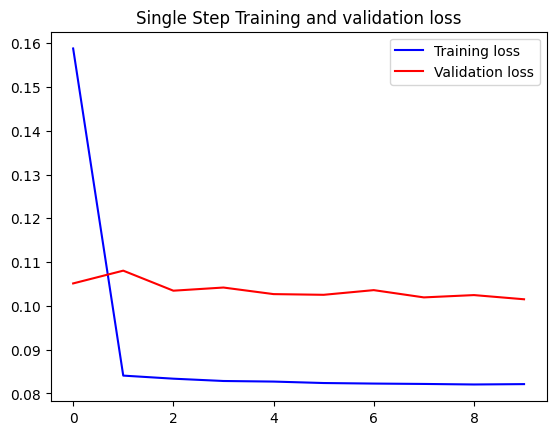

In [ ]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

Прогнозируем тренировочные данные обученной моделью

In [ ]:
train_predict = single_step_model.predict(x_train_single)
train_predict

178/178 [==============================] - 2s 11ms/step


array([[ 0.1423735 ,  0.15692285,  0.16227531],
       [ 0.02685061,  0.04548052,  0.04604333],
       [-0.06247359, -0.04062334, -0.04927882],
       ...,
       [-0.8970046 , -0.8861058 , -0.87787044],
       [-0.8604152 , -0.8523072 , -0.8358449 ],
       [-0.7984898 , -0.79684013, -0.7878995 ]], dtype=float32)

Снова визуализация

<Axes: >

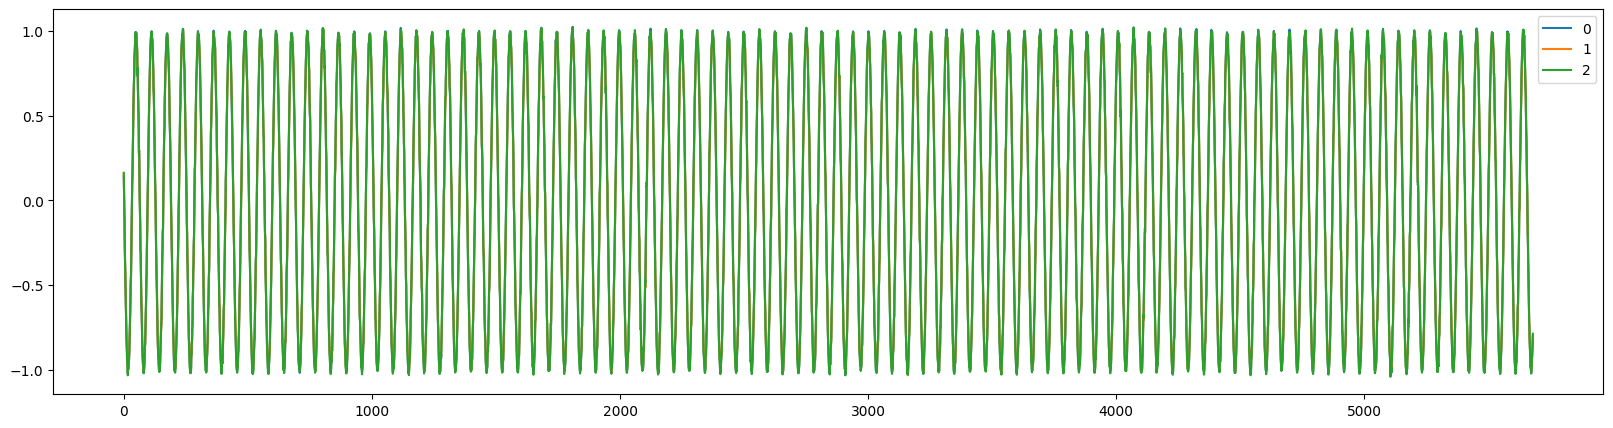

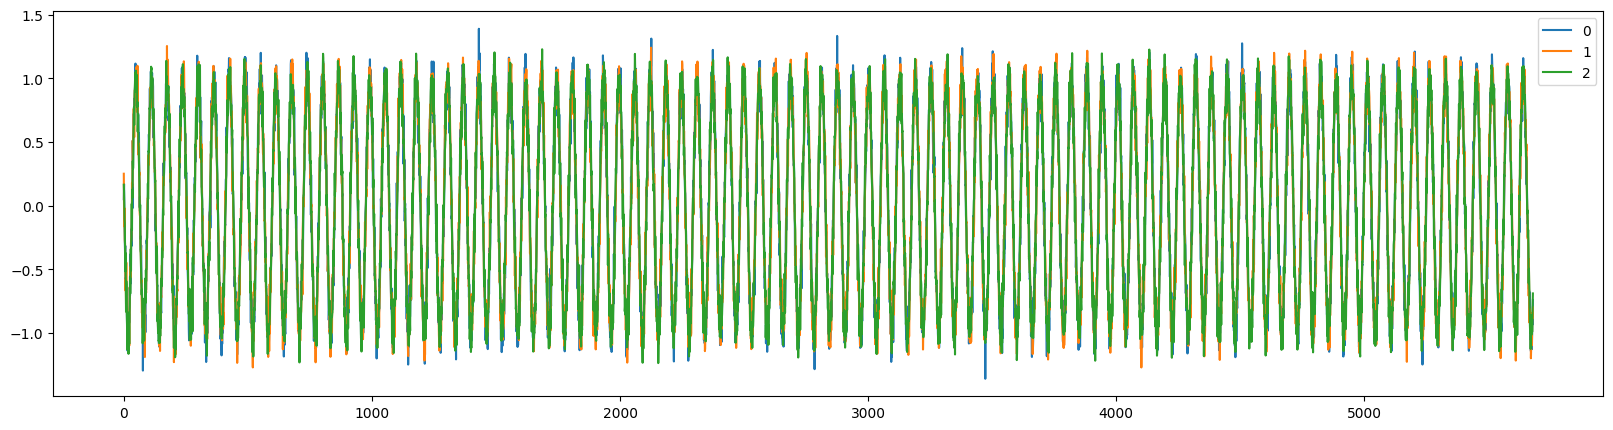

In [ ]:
pd.DataFrame(train_predict).plot(figsize = (20, 5))
pd.DataFrame(y_train_single).plot(figsize = (20, 5))

In [ ]:
# train_predict - y_train_single

In [ ]:
# pd.DataFrame(abs(train_predict - y_train_single)).plot(figsize = (20, 10))

Создаем массив из трёх столбцов из модулей разницы между спрогнозируемыми значениями и реальными

In [ ]:
train_abs_Dif = np.array(abs(train_predict - y_train_single))
train_abs_Dif

array([[0.09192596, 0.0932384 , 0.00162715],
       [0.14310392, 0.0686055 , 0.06537224],
       [0.02647404, 0.12294001, 0.04751758],
       ...,
       [0.0523157 , 0.04533188, 0.01260261],
       [0.07271542, 0.03160207, 0.05097022],
       [0.0574912 , 0.00219691, 0.09824461]])

Суммируем столбцы и получаем массив из одного столбца

In [ ]:
train_abs_Dif_sum = train_abs_Dif.sum(axis = 1)
train_abs_Dif_sum

array([0.18679151, 0.27708165, 0.19693163, ..., 0.11025019, 0.15528771,
       0.15793272])

Снова визуализация

<Axes: >

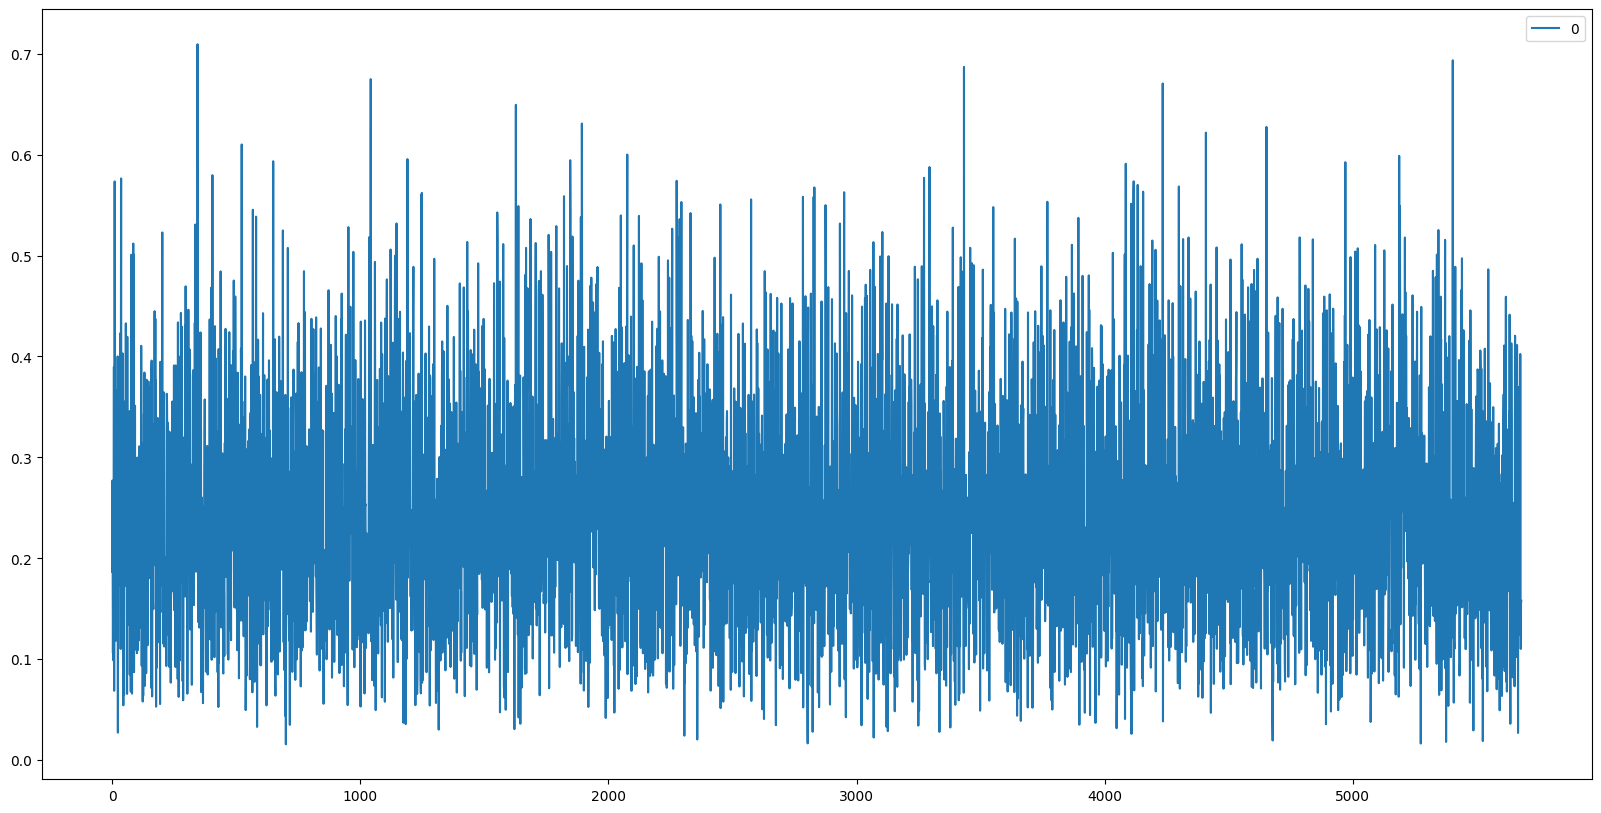

In [ ]:
 pd.DataFrame(train_abs_Dif_sum).plot(figsize = (20, 10))

Создаём трешхолд, выбирая максимальное значение на трейне

In [ ]:
treshold = np.amax(train_abs_Dif_sum, axis = None)
treshold

0.7093029784816818

Прогнозируем тестовые данные

In [ ]:
test_predict = single_step_model.predict(x_test_single)

40/40 [==============================] - 0s 11ms/step


Снова получаем массив из трёх столбцов из модулей разницы между спрогнозируемыми значениями и реальными на тесте

In [ ]:
test_predict.shape

(1279, 3)

In [ ]:
test_abs_Dif = np.array(abs(test_predict - y_test_single))

Снова визуализация

<Axes: >

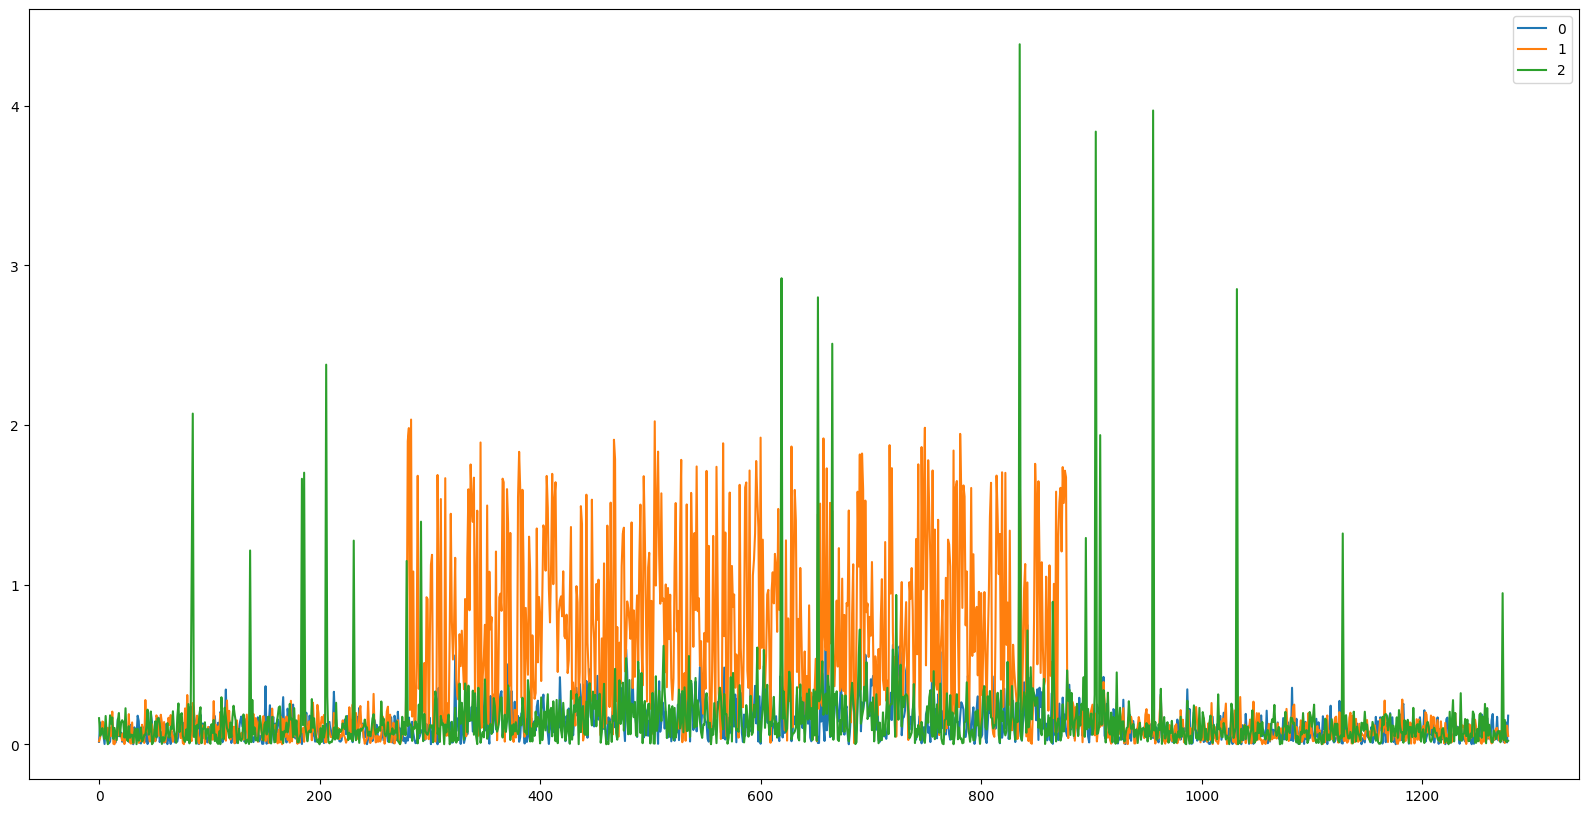

In [ ]:
pd.DataFrame(test_abs_Dif).plot(figsize = (20, 10))

Суммируем стобцы массива и получаем ммассив из одного столбца


In [ ]:
test_abs_Dif_sum = test_abs_Dif.sum(axis = 1)
test_abs_Dif_sum

array([0.19743738, 0.23395509, 0.21915654, ..., 0.26878329, 0.14490632,
       0.25367053])

<Axes: >

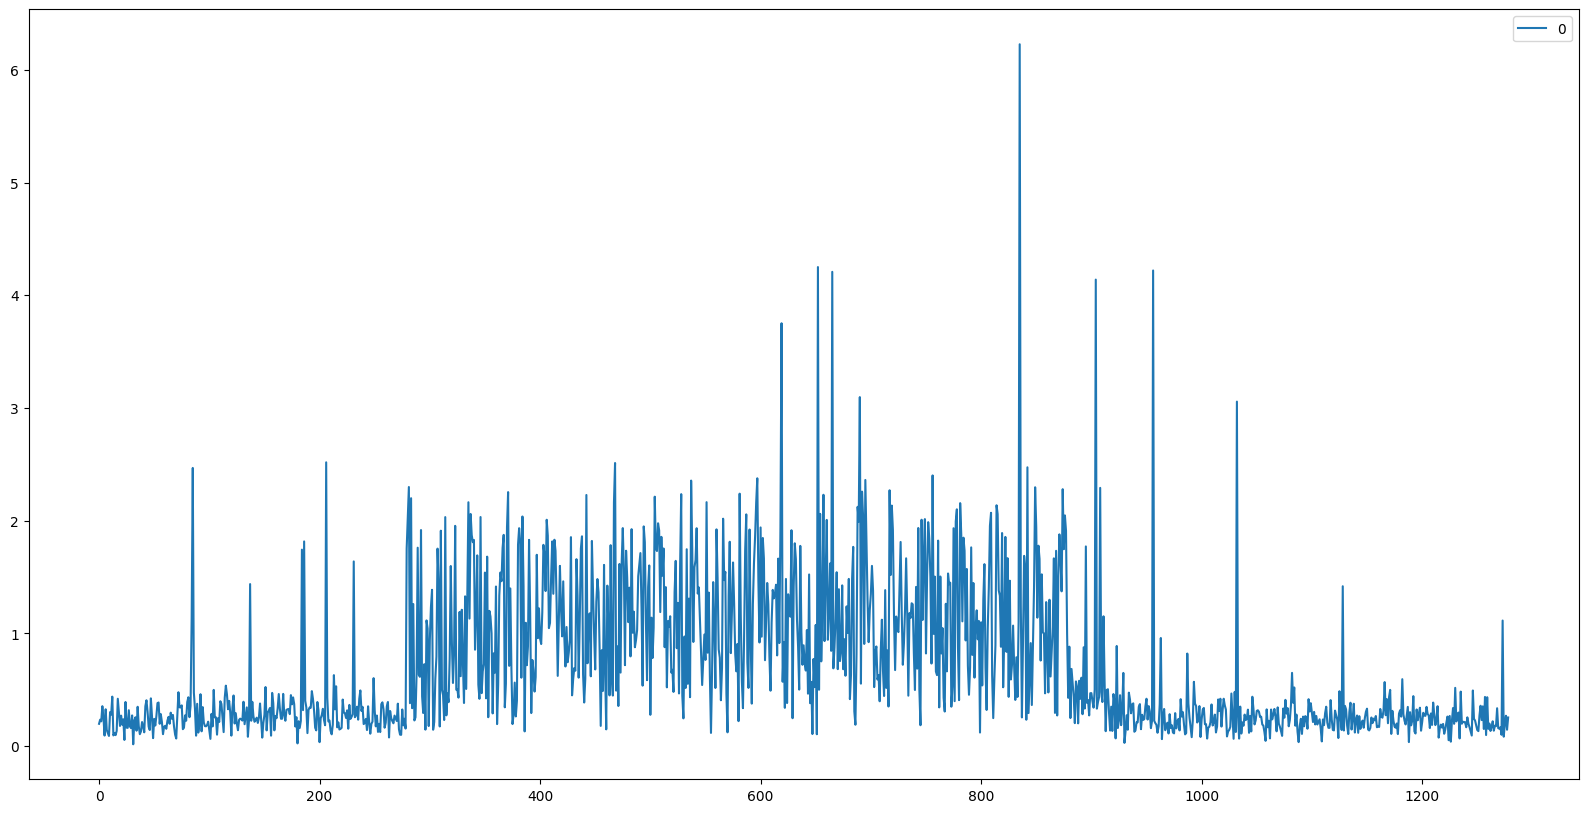

In [ ]:
pd.DataFrame(test_abs_Dif_sum).plot(figsize = (20, 10))

Сравниваем все значения с трешхолдом и выводим необходиме значения столбца 'isAnomaly'

In [ ]:
returned_arr = np.array(list(map(lambda x: int(x > treshold), test_abs_Dif_sum)))
returned_arr[returned_arr == 1] = -1
returned_arr[returned_arr == 0] = 1
returned_arr

array([1, 1, 1, ..., 1, 1, 1])

Создаем массив из 720 единиц, т.к. первые 720 значений которые анализирует модель для прогноза, мы считаем как неаномальные

In [ ]:
zeros = np.zeros((720,), dtype=int)
zeros[zeros == 0] = 1
zeros

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Создаём итоговый массив, склеивая массив из единиц с получившимися значеними столбца

In [ ]:
returner = np.concatenate((zeros, returned_arr), axis=None)
returner = returner.reshape(1999, 1)
returner.shape

(1999, 1)

In [ ]:
test_part = (full_df[8000 : 9999])
test_part

array([[ 0.92205773,  1.03907766,  0.99969139,  0.        ],
       [ 0.84087247,  0.70179973,  0.69620746,  0.        ],
       [ 0.86044593,  0.73264581, -2.00245138,  3.        ],
       ...,
       [ 0.56713788,  0.52870847,  0.38939239,  0.        ],
       [ 0.75177542,  0.71032981,  0.64710867,  0.        ],
       [ 0.67358569,  0.78540688,  0.71304061,  0.        ]])

In [ ]:
dataset_w_anomals = np.concatenate((test_part, returner), axis = 1)
dataset_w_anomals

array([[ 0.92205773,  1.03907766,  0.99969139,  0.        ,  1.        ],
       [ 0.84087247,  0.70179973,  0.69620746,  0.        ,  1.        ],
       [ 0.86044593,  0.73264581, -2.00245138,  3.        ,  1.        ],
       ...,
       [ 0.56713788,  0.52870847,  0.38939239,  0.        ,  1.        ],
       [ 0.75177542,  0.71032981,  0.64710867,  0.        ,  1.        ],
       [ 0.67358569,  0.78540688,  0.71304061,  0.        ,  1.        ]])

In [ ]:
data_sint = pd.DataFrame(dataset_w_anomals).iloc[0:]
data_sint[4].value_counts()

 1.0    1554
-1.0     445
Name: 4, dtype: int64

In [ ]:
data_sint

,0,1,2,3,4
0,0.922058,1.039078,0.999691,0.0,1.0
1,0.840872,0.701800,0.696207,0.0,1.0
2,0.860446,0.732646,-2.002451,3.0,1.0
3,0.577888,0.738106,0.743365,0.0,1.0
4,0.590559,0.578583,0.476709,0.0,1.0
...,...,...,...,...,...
1994,0.252793,0.256042,-0.584863,3.0,1.0
1995,0.419634,0.458820,0.415782,0.0,1.0
1996,0.567138,0.528708,0.389392,0.0,1.0
1997,0.751775,0.710330,0.647109,0.0,1.0


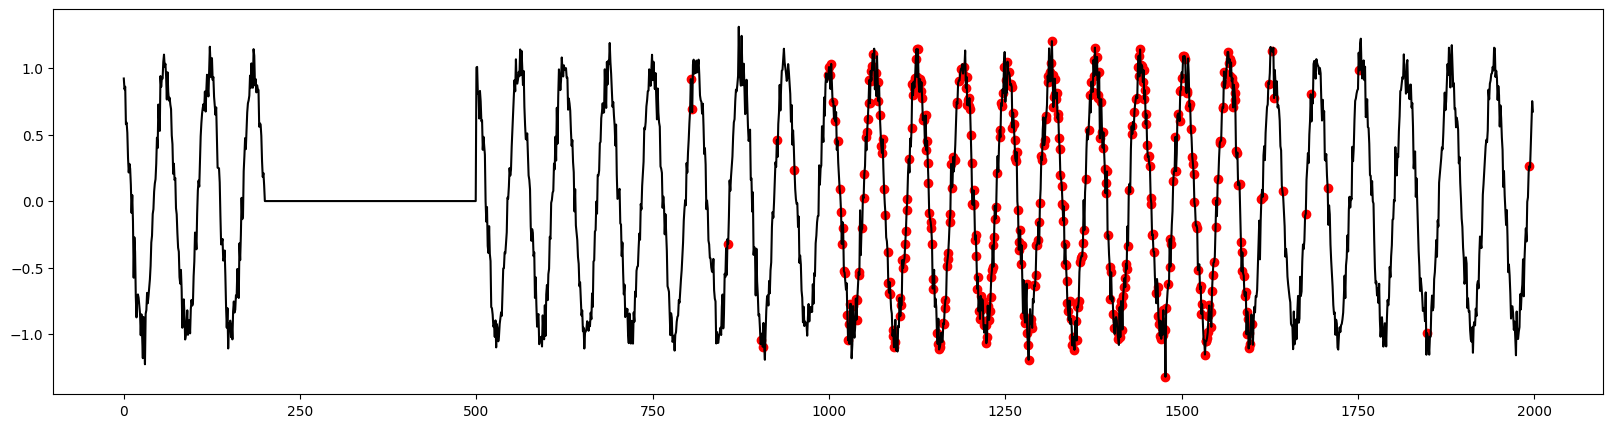

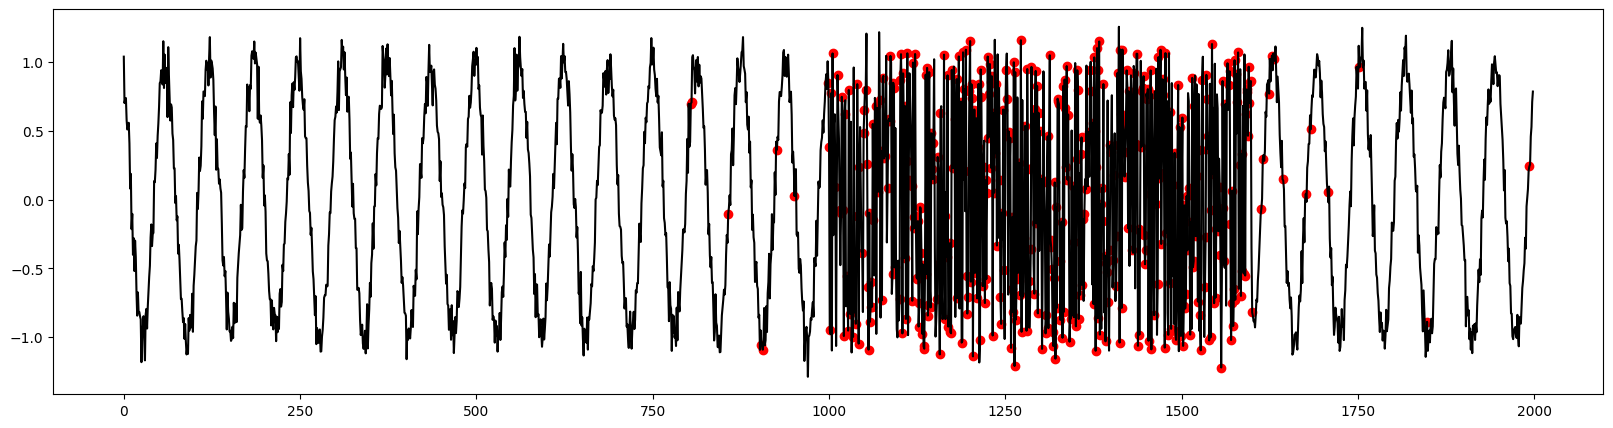

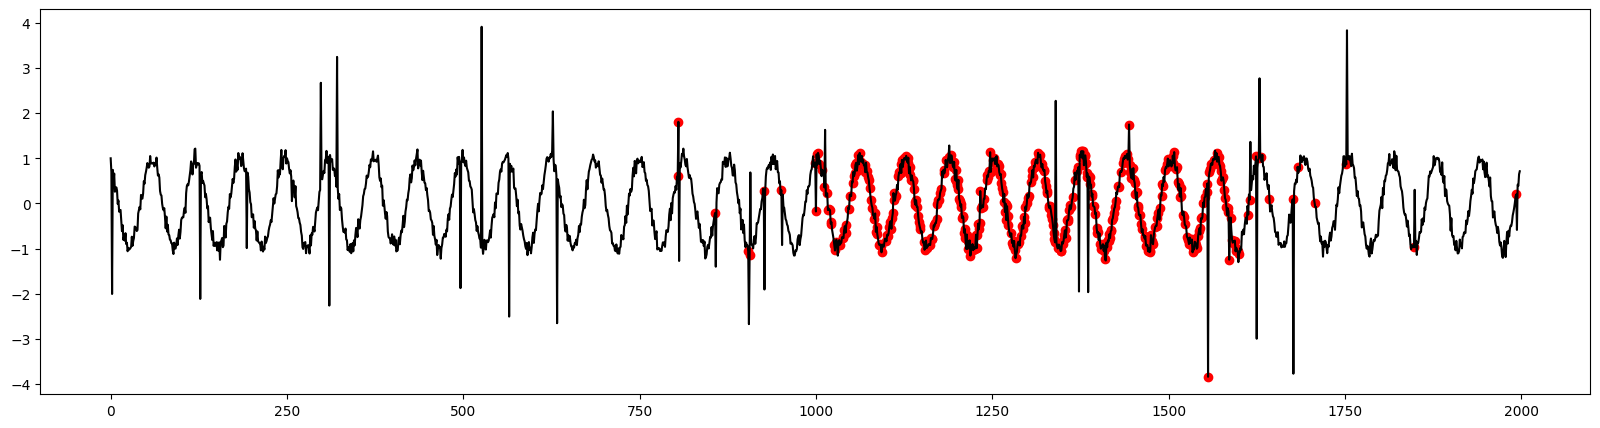

In [ ]:
plt.figure(figsize = (20,5))
plt.plot(data_sint[0].index, data_sint[0], color = 'black')
plt.scatter(data_sint[data_sint[4] == -1].index, data_sint[data_sint[4] == -1][0], color = 'red')
plt.figure(figsize = (20,5))
plt.plot(data_sint[1].index, data_sint[1], color = 'black')
plt.scatter(data_sint[data_sint[4] == -1].index, data_sint[data_sint[4] == -1][1], color = 'red')
plt.figure(figsize = (20,5))
plt.plot(data_sint[2].index, data_sint[2], color = 'black')
plt.scatter(data_sint[data_sint[4] == -1].index, data_sint[data_sint[4] == -1][2], color = 'red')

In [ ]:
# import sklearn.metrics
# y_true = data_sint[3].to_numpy()
# y_pred = data_sint[4].to_numpy()

# precision = sklearn.metrics.precision_score(y_true, y_pred, pos_label=1)
# print('precision', precision)
# recall = sklearn.metrics.recall_score(y_true, y_pred, pos_label=1)
# print('recall', recall)
# f1_score = sklearn.metrics.f1_score(y_true, y_pred, pos_label=1)
# print('f1_score', f1_score)

In [ ]:
data_sint[5] = 0

In [ ]:
for i in range (0, len(data_sint)):
  if ((int(data_sint[3][i])!=0) & (int(data_sint[4][i])==-1.0)):
    data_sint[5][i] = 1
  if ((int(data_sint[3][i])==0) & (int(data_sint[4][i])==1)):
    data_sint[5][i] = 1
  else:
    data_sint[5][i] = 0
data_sint

<ipython-input-47-07547f3b0d37>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sint[5][i] = 1
<ipython-input-47-07547f3b0d37>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sint[5][i] = 0
<ipython-input-47-07547f3b0d37>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sint[5][i] = 1


,0,1,2,3,4,5
0,0.922058,1.039078,0.999691,0.0,1.0,1
1,0.840872,0.701800,0.696207,0.0,1.0,1
2,0.860446,0.732646,-2.002451,3.0,1.0,0
3,0.577888,0.738106,0.743365,0.0,1.0,1
4,0.590559,0.578583,0.476709,0.0,1.0,1
...,...,...,...,...,...,...
1994,0.252793,0.256042,-0.584863,3.0,1.0,0
1995,0.419634,0.458820,0.415782,0.0,1.0,1
1996,0.567138,0.528708,0.389392,0.0,1.0,1
1997,0.751775,0.710330,0.647109,0.0,1.0,1


In [ ]:
# plt.figure(figsize = (20,3))

# plt.plot(data_sint[0].index, data_sint[0], color = 'black')
# #Аномалии реальные, кторые метод не вычислил
# plt.scatter(data_sint[((data_sint[3] == -1) & (data_sint[4] == 1))].index, data_sint[((data_sint[3] == -1) & (data_sint[4] == 1))][0], color = 'green')
# #Аномалии, которые вычислил метод
# plt.scatter(data_sint[((data_sint[3] == -1) & (data_sint[4] == -1))].index,
# data_sint[((data_sint[3] == -1) & (data_sint[4] == -1))][0], color = 'blue')
# #Нормальные значения, которые метод нашел ошибочно
# plt.scatter(data_sint[((data_sint[3] == 1) & (data_sint[4] == -1))].index, data_sint[((data_sint[3] == 1) & (data_sint[4] == -1))][0], color = 'red')

In [ ]:
# plt.figure(figsize = (20,3))

# plt.plot(data_sint[1].index, data_sint[1], color = 'black')
# #Аномалии реальные, кторые метод не вычислил
# plt.scatter(data_sint[((data_sint[3] == -1) & (data_sint[4] == 1))].index, data_sint[((data_sint[3] == -1) & (data_sint[4] == 1))][1], color = 'green')
# #Аномалии, которые вычислил метод
# plt.scatter(data_sint[((data_sint[3] == -1) & (data_sint[4] == -1))].index,
# data_sint[((data_sint[3] == -1) & (data_sint[4] == -1))][1], color = 'blue')
# #Нормальные значения, которые метод нашел ошибочно
# plt.scatter(data_sint[((data_sint[3] == 1) & (data_sint[4] == -1))].index, data_sint[((data_sint[3] == 1) & (data_sint[4] == -1))][1], color = 'red')

In [ ]:
# plt.figure(figsize = (20,3))

# plt.plot(data_sint[2].index, data_sint[2], color = 'black')
# #Аномалии реальные, кторые метод не вычислил
# plt.scatter(data_sint[((data_sint[3] == -1) & (data_sint[4] == 1))].index, data_sint[((data_sint[3] == -1) & (data_sint[4] == 1))][2], color = 'green')
# #Аномалии, которые вычислил метод
# plt.scatter(data_sint[((data_sint[3] == -1) & (data_sint[4] == -1))].index,
# data_sint[((data_sint[3] == -1) & (data_sint[4] == -1))][2], color = 'blue')
# #Нормальные значения, которые метод нашел ошибочно
# plt.scatter(data_sint[((data_sint[3] == 1) & (data_sint[4] == -1))].index, data_sint[((data_sint[3] == 1) & (data_sint[4] == -1))][2], color = 'red')

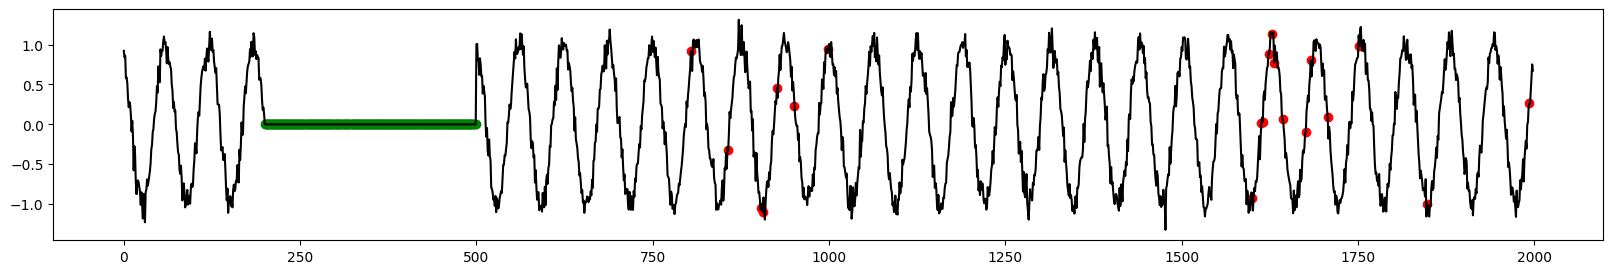

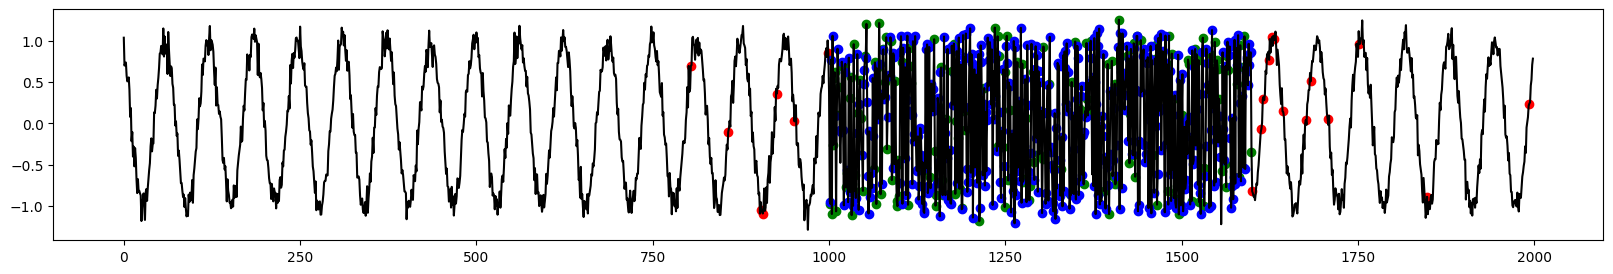

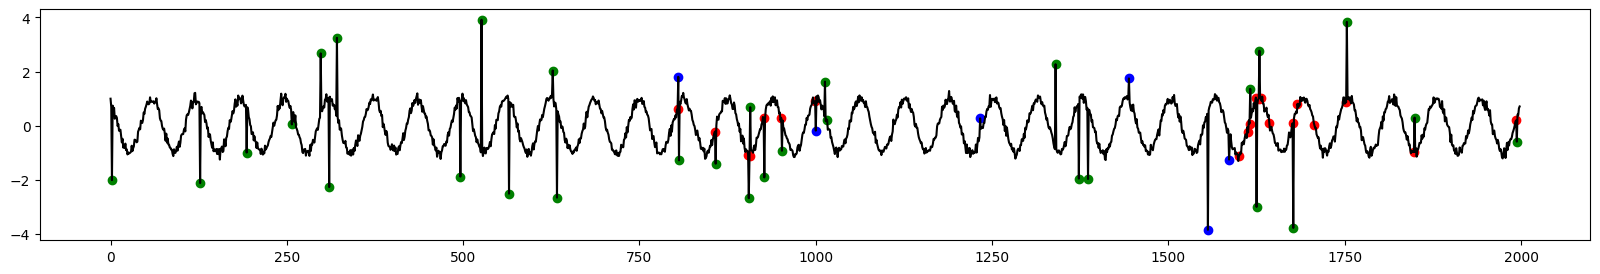

In [ ]:
plt.figure(figsize = (20,3))
plt.plot(data_sint[0].index, data_sint[0], color = 'black')
#Нормальные значения, которые метод нашел ошибочно
plt.scatter(data_sint[((data_sint[3] == 0) & (data_sint[4] == -1))].index,
            data_sint[((data_sint[3] == 0) & (data_sint[4] == -1))][0], color = 'red')
#Аномалии реальные, кторые метод не вычислил
plt.scatter(data_sint[((data_sint[3] == 1) & (data_sint[4] == 1))].index,
            data_sint[((data_sint[3] == 1) & (data_sint[4] == 1))][0], color = 'green')
#Аномалии, которые вычислил метод
plt.scatter(data_sint[((data_sint[3] == 1) & (data_sint[4] == -1))].index,
data_sint[((data_sint[3] == 1) & (data_sint[4] == -1))][0], color = 'blue')

plt.figure(figsize = (20,3))
plt.plot(data_sint[1].index, data_sint[1], color = 'black')
#Нормальные значения, которые метод нашел ошибочно
plt.scatter(data_sint[((data_sint[3] == 0) & (data_sint[4] == -1))].index,
            data_sint[((data_sint[3] == 0) & (data_sint[4] == -1))][1], color = 'red')
#Аномалии реальные, кторые метод не вычислил
plt.scatter(data_sint[((data_sint[3] == 2) & (data_sint[4] == 1))].index,
            data_sint[((data_sint[3] == 2) & (data_sint[4] == 1))][1], color = 'green')
#Аномалии, которые вычислил метод
plt.scatter(data_sint[((data_sint[3] == 2) & (data_sint[4] == -1))].index,
data_sint[((data_sint[3] == 2) & (data_sint[4] == -1))][1], color = 'blue')

plt.figure(figsize = (20,3))
plt.plot(data_sint[2].index, data_sint[2], color = 'black')
#Нормальные значения, которые метод нашел ошибочно
plt.scatter(data_sint[((data_sint[3] == 0) & (data_sint[4] == -1))].index,
            data_sint[((data_sint[3] == 0) & (data_sint[4] == -1))][2], color = 'red')
#Аномалии реальные, кторые метод не вычислил
plt.scatter(data_sint[((data_sint[3] == 3) & (data_sint[4] == 1))].index,
            data_sint[((data_sint[3] == 3) & (data_sint[4] == 1))][2], color = 'green')
#Аномалии, которые вычислил метод
plt.scatter(data_sint[((data_sint[3] == 3) & (data_sint[4] == -1))].index,
data_sint[((data_sint[3] == 3) & (data_sint[4] == -1))][2], color = 'blue')